## Packages import

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
!pip install pytesseract

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import json

# Optional OCR tools
import pytesseract
from PIL import Image
# or use EasyOCR:
# import easyocr

In [4]:
# PyTorch
import torch

# Check GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'使用 GPU：{torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('使用 CPU')

使用 GPU：NVIDIA L4


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
os.chdir("/content/drive/MyDrive/Database")

## Pre Processing

In [8]:
def load_and_merge(subject: str) -> pd.DataFrame:
    """
    Load question bank and chapter list CSVs for a given subject from Database/{subject}_Database and merge on chapter ID.

    Args:
        subject: 'math' or 'social'
    Returns:
        DataFrame with columns: question_text, chapter_name, subject
    """
    base_path = f"{subject}_Database"
    qbank_path = f"{base_path}/{subject}_question_bank.csv"
    chap_path = f"{base_path}/{subject}_chapter_list.csv"

    qdf = pd.read_csv(qbank_path)
    cdf = pd.read_csv(chap_path)
    qdf.columns = qdf.columns.str.strip().str.lower().str.replace(' ', '_')
    cdf.columns = cdf.columns.str.strip().str.lower().str.replace(' ', '_')

    print("Question Bank Columns:", qdf.columns.tolist())
    print("Chapter List Columns:", cdf.columns.tolist())


    df = qdf.merge(cdf, on='section_name', how='left')
    df['subject'] = subject
    return df

# Load and combine data from correct paths
# df = pd.concat([load_and_merge('math'), load_and_merge('social'), load_and_merge('chinese'), load_and_merge('science'), load_and_merge('english')], ignore_index=True)
df = pd.concat([load_and_merge('math'), load_and_merge('social'), load_and_merge('science')], ignore_index=True)
# df = pd.concat([load_and_merge('chinese')], ignore_index=True)

df.count()
df.head()


Question Bank Columns: ['subject', 'ques_no', 'chapter_name', 'section_name', 'ques_detl']
Chapter List Columns: ['year_grade', 'book', 'chapter_num', 'chapter_name', 'section_num', 'section_name']
Question Bank Columns: ['subject', 'ques_no', 'chapter_name', 'section_name', 'ques_detl']
Chapter List Columns: ['year_grade', 'book', 'chapter_num', 'chapter_name', 'section_num', 'section_name']
Question Bank Columns: ['subject', 'ques_no', 'chapter_name', 'section_name', 'ques_detl']
Chapter List Columns: ['year_grade', 'book', 'chapter_num', 'chapter_name', 'section_num', 'section_name']


,subject,ques_no,chapter_name_x,section_name,ques_detl,year_grade,book,chapter_num,chapter_name_y,section_num
0,math,2MA0810001,整數的運算,負數與數線,以中午12時為基準，下午3時記作＋3，那麼上午10時可以記作多少？(A)＋10(B)－10(...,8.0,1.0,1.0,整數的運算,1.0
1,math,2MA0810002,整數的運算,負數與數線,若數學科成績以30分為基準，得40分記作＋10，那麼考25分可記作多少？ (A)－25 (B...,8.0,1.0,1.0,整數的運算,1.0
2,math,2MA0810003,整數的運算,負數與數線,如果以正午12時為基準，當日下午4時用＋4表示，則當日上午8時應記為多少？ (A)－8 (B...,8.0,1.0,1.0,整數的運算,1.0
3,math,2MA0810004,整數的運算,負數與數線,如果以中午12時為基準，當日下午2時記為＋8，則當日上午6時應記為多少？(A)－24(B)－...,8.0,1.0,1.0,整數的運算,1.0
4,math,2MA0810005,整數的運算,負數與數線,如果＋40°表示北緯40°，則南緯30°該如何表示？ (A)30° (B)－30° (C)...,8.0,1.0,1.0,整數的運算,1.0


In [9]:
df = df[['subject','chapter_name_x','section_name','ques_detl']]
df.head()

,subject,chapter_name_x,section_name,ques_detl
0,math,整數的運算,負數與數線,以中午12時為基準，下午3時記作＋3，那麼上午10時可以記作多少？(A)＋10(B)－10(...
1,math,整數的運算,負數與數線,若數學科成績以30分為基準，得40分記作＋10，那麼考25分可記作多少？ (A)－25 (B...
2,math,整數的運算,負數與數線,如果以正午12時為基準，當日下午4時用＋4表示，則當日上午8時應記為多少？ (A)－8 (B...
3,math,整數的運算,負數與數線,如果以中午12時為基準，當日下午2時記為＋8，則當日上午6時應記為多少？(A)－24(B)－...
4,math,整數的運算,負數與數線,如果＋40°表示北緯40°，則南緯30°該如何表示？ (A)30° (B)－30° (C)...


In [ ]:
df.count()

,0
subject,40341
chapter_name_x,40341
section_name,40341
ques_detl,40341


In [ ]:
len(df)

40341

In [10]:
# 2. Label Encoding chapter name
# Combine subject and chapter_name as classification label

df['label_str'] = df['subject'] + '::' + df['chapter_name_x']
label2id_chapter = {lab: i for i, lab in enumerate(sorted(df['label_str'].unique()))}
id2label_chapter = {i: lab for lab, i in label2id_chapter.items()}
df['label_chapter'] = df['label_str'].map(label2id_chapter)

In [11]:
# 2. Label Encoding section name

df['label_str'] = df['subject'] + '::' + df['chapter_name_x'] + '::' + df['section_name']
label2id_section = {lab: i for i, lab in enumerate(sorted(df['label_str'].unique()))}
id2label_section = {i: lab for lab, i in label2id_section.items()}  # ← 這一行加上
df['label_section'] = df['label_str'].map(label2id_section)

In [12]:
# label section further processing
label_counts = df['label_section'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df = df[df['label_section'].isin(valid_labels)]
print(len(df))

40339


In [17]:
df['label'].tail()

,label
40336,57
40337,57
40338,57
40339,57
40340,57


In [30]:
print(id2label_section)

{0: 'math::一元一次不等式::解一元一次不等式', 1: 'math::一元一次不等式::認識一元一次不等式', 2: 'math::一元一次方程式::一元一次方程式', 3: 'math::一元一次方程式::代數式的化簡', 4: 'math::一元二次方程式::因式分解解一元二次方程式', 5: 'math::一元二次方程式::配方法與公式解', 6: 'math::三角形的基本性質::三角形的全等性質', 7: 'math::三角形的基本性質::三角形的邊角關係', 8: 'math::三角形的基本性質::三角形與多邊形的內角與外角', 9: 'math::三角形的基本性質::中垂線與角平分線的性質', 10: 'math::三角形的基本性質::中垂腺與角平分線', 11: 'math::三角形的基本性質::尺規作圖', 12: 'math::乘法公式與多項式::乘法公式', 13: 'math::乘法公式與多項式::多項式的乘除運算', 14: 'math::乘法公式與多項式::多項式與其加減運算', 15: 'math::二元一次聯立方程式::二元一次方程式', 16: 'math::二元一次聯立方程式::應用問題', 17: 'math::二元一次聯立方程式::解二元一次聯立方程式', 18: 'math::二次函數::二次函數的圖形與最大值、最小值', 19: 'math::函數::函數與函數圖形', 20: 'math::分數的運算::分數的四則運算', 21: 'math::分數的運算::因數與倍數', 22: 'math::分數的運算::指數律', 23: 'math::分數的運算::最大公因數與最小公倍數', 24: 'math::因式分解::利用十字交乘法做因式分解', 25: 'math::因式分解::利用提公因式與乘法公式做因式分解', 26: 'math::圓::圓心角、圓周角與弧的關係', 27: 'math::圓::點、直線與圓之間的位置關係', 28: 'math::平方根與畢氏定理::平方根與近似值', 29: 'math::平方根與畢氏定理::根式的運算', 30: 'math::平方根與畢氏定理::畢氏定理', 31: 'math::平行與四邊形::平行', 32: 'math::平行與四邊形::平行四邊形', 3

In [11]:
!apt-get -y install fonts-noto-cjk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 6s (11.0 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [14]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-06-05 05:27:29--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.170.101, 64.233.170.102, 64.233.170.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-05 05:27:30--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  34.0MB/s    in 0.6s    

2025-06-05 05:27:

### 前處理視覺化

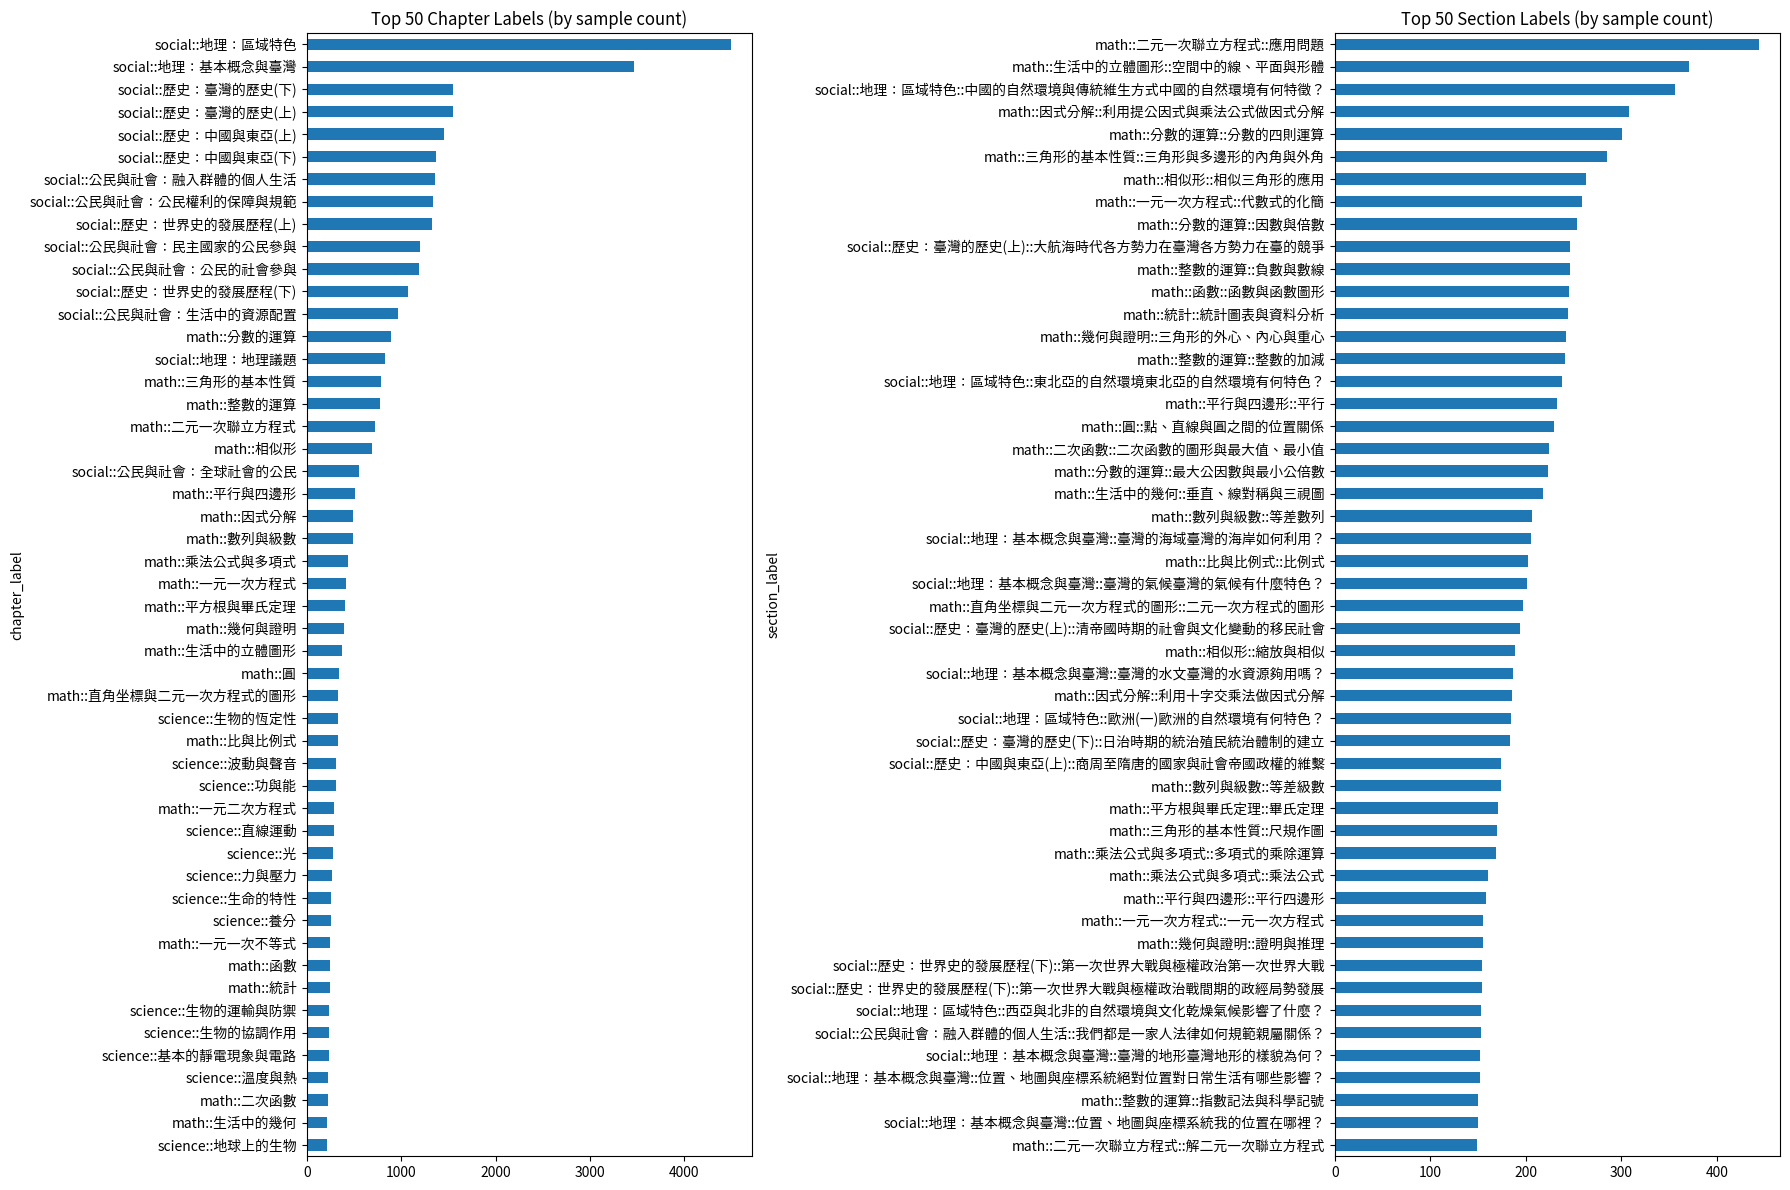

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'Noto Sans CJK TC'  # Colab 通用中文字

# 統計 chapter_label
df['chapter_label'] = df['subject'] + '::' + df['chapter_name_x']
chapter_counts = df['chapter_label'].value_counts().sort_values(ascending=False)

# 統計 section_label
df['section_label'] = df['subject'] + '::' + df['chapter_name_x'] + '::' + df['section_name']
section_counts = df['section_label'].value_counts().sort_values(ascending=False)

# 畫圖
fig, axes = plt.subplots(1, 2, figsize=(18, 12))
chapter_counts.head(50).plot(kind='barh', ax=axes[0], title='Top 50 Chapter Labels (by sample count)')
section_counts.head(50).plot(kind='barh', ax=axes[1], title='Top 50 Section Labels (by sample count)')
axes[0].invert_yaxis()
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 6/5 多模型架構pipeline（待測試）
architectures = [
    {
        'name': 'bert-base-uncased',
        'tokenizer_cls': BertTokenizerFast,
        'model_cls': BertForSequenceClassification
    },
    {
        'name': 'roberta-base',
        'tokenizer_cls': RobertaTokenizerFast,
        'model_cls': RobertaForSequenceClassification
    },
    {
        'name': 'bert-base-uncased-dora',  # 假设这是 DoRA 版本权重 ID
        'tokenizer_cls': BertTokenizerFast,
        'model_cls': BertForSequenceClassification
    },
    # 如果还有别的模型，以此类推
]

results = {}
for arch in architectures:
    tokenizer = arch['tokenizer_cls'].from_pretrained(arch['name'])
    model = arch['model_cls'].from_pretrained(arch['name'], num_labels=num_labels)

    # 这里简单示意，你可以把 train_and_evaluate 拆分出 tokenizer/model 初始化
    metrics = train_and_evaluate(
        train_texts, train_labels,
        test_texts, test_labels,
        num_labels, id2label_map,
        output_dir=f'./output_{arch["name"]}',
        num_epochs=8, batch_size=16, lr=5e-5
    )
    results[arch['name']] = metrics

print(results)


In [13]:
# 6/5 Pipeline版的train-test split
from sklearn.model_selection import train_test_split

# 2.1 章節分類的切分
chap_train, chap_test = train_test_split(
    df[['ques_detl','label_chapter']],
    test_size=0.1,
    stratify=df['label_chapter'],
    random_state=42
)
chap_train = chap_train.rename(columns={'label_chapter': 'label'})
chap_test  = chap_test.rename(columns={'label_chapter': 'label'})

# 2.2 節分類的切分
sec_train, sec_test = train_test_split(
    df[['ques_detl','label_section']],
    test_size=0.1,
    stratify=df['label_section'],
    random_state=42
)
sec_train = sec_train.rename(columns={'label_section': 'label'})
sec_test  = sec_test.rename(columns={'label_section': 'label'})


In [14]:
# 6/5 chapter和section同時訓練的pipeline

import torch
from torch.utils.data import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import time

# 2.1.1 自訂 Dataset，generic for any label 整數
class QDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 2.1.2 訓練 + 評估的公用函式
def train_and_evaluate(
    train_texts, train_labels,
    test_texts, test_labels,
    num_labels, id2label_map, output_dir,
    num_epochs=8, batch_size=16, lr=5e-5
):
    """
    輸入：訓練 texts, labels；測試 texts, labels；label 數量；id2label 對應；儲存目錄；訓練超參數
    輸出：一個 dict，包含 accuracy, f1, precision, recall, train_time, model_size
    同時會把模型存到 output_dir 目錄底下
    """
    # Tokenizer + Model
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    )

    # 建立 Dataset
    train_dataset = QDataset(train_texts, train_labels, tokenizer)
    eval_dataset  = QDataset(test_texts, test_labels,   tokenizer)

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy='epoch',
        #save_strategy='epoch',
        save_strategy='no',           # 訓練過程不自動存 checkpoint
        learning_rate=lr,
        load_best_model_at_end=False, # 無論如何都先採用最後的epoch（為了省空間）
        metric_for_best_model="f1_macro", #'accuracy',
        #logging_strategy="no"         # 不要產生 TensorBoard log
        #logging_steps=50,
        #logging_dir=f'{output_dir}/logs'
        logging_steps=50,             # ✅ 每 50 step 顯示一次 log（console）
        logging_strategy='steps',     # ✅ 使用步數作為 log 判斷基準
        report_to=[]                  # ✅ 禁止寫入 TensorBoard / WandB / Comet
    )

    # 定義 metric
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        acc = accuracy_score(labels, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(
            labels, preds, average='macro', zero_division=0
        )
        return {
            'accuracy': acc,
            'precision_macro': prec,
            'recall_macro': rec,
            'f1_macro': f1
        }

    # 初始化 Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    # 開始計時並訓練
    start_time = time.time()
    trainer.train()
    elapsed = time.time() - start_time

    # 最佳模型；跑一次最終評估
    metrics = trainer.evaluate()
    # metrics 會有 keys: eval_accuracy, eval_precision_macro, eval_recall_macro, eval_f1_macro

    # 儲存模型
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    # 同時把 id2label_map、label2id_map 存下來
    import json
    with open(f"{output_dir}/id2label.json", 'w') as f:
        json.dump(id2label_map, f)
    # model size: 用檔案大小來衡量
    import os
    total_size = 0
    for root, _, files in os.walk(output_dir):
        for fname in files:
            total_size += os.path.getsize(os.path.join(root, fname))

    # 回傳統整結果
    return {
        'accuracy':    metrics['eval_accuracy'],
        'precision':   metrics['eval_precision_macro'],
        'recall':      metrics['eval_recall_macro'],
        'f1':          metrics['eval_f1_macro'],
        'train_time':  elapsed,
        'model_size':  total_size
    }


In [ ]:
# 6/5 training

# 3.1 準備章節分類的資料
chap_texts_train = chap_train['ques_detl'].tolist()
chap_labels_train= chap_train['label'].tolist()
chap_texts_test  = chap_test ['ques_detl'].tolist()
chap_labels_test = chap_test ['label'].tolist()
num_chap_labels  = len(label2id_chapter)

# 3.2 準備節分類的資料
sec_texts_train = sec_train['ques_detl'].tolist()
sec_labels_train= sec_train['label'].tolist()
sec_texts_test  = sec_test ['ques_detl'].tolist()
sec_labels_test = sec_test ['label'].tolist()
num_sec_labels  = len(label2id_section)

# 3.3 跑章節分類實驗
chap_res = train_and_evaluate(
    chap_texts_train, chap_labels_train,
    chap_texts_test,  chap_labels_test,
    num_labels = num_chap_labels,
    id2label_map = id2label_chapter,
    output_dir = './saved_model_chapter',
    num_epochs=8, batch_size=16, lr=5e-5
)
print("Chapter-level Results:", chap_res)

# 3.4 跑節分類實驗
sec_res = train_and_evaluate(
    sec_texts_train, sec_labels_train,
    sec_texts_test,  sec_labels_test,
    num_labels = num_sec_labels,
    id2label_map = id2label_section,
    output_dir = './saved_model_section',
    num_epochs=8, batch_size=16, lr=5e-5
)
print("Section-level Results:", sec_res)

# 3.5 比較兩種結果
import pandas as pd
comparison = pd.DataFrame({
    'metric':    ['accuracy','precision','recall','f1','train_time','model_size'],
    'chapter':   [chap_res[k] for k in ['accuracy','precision','recall','f1','train_time','model_size']],
    'section':   [sec_res[k]  for k in ['accuracy','precision','recall','f1','train_time','model_size']]
})
print(comparison)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,2.028312,0.408280,0.163002,0.177435,0.136402
2,No log,1.485171,0.564700,0.396570,0.352836,0.341685
3,No log,1.223709,0.646505,0.535346,0.487441,0.491673
4,No log,1.129700,0.670798,0.584364,0.545578,0.544364
5,No log,1.065955,0.706991,0.603950,0.583489,0.583905
6,No log,1.054519,0.714179,0.631386,0.604169,0.606831
7,No log,1.099218,0.721616,0.622903,0.608429,0.609487
8,No log,1.102599,0.727070,0.647454,0.622350,0.626948


Chapter-level Results: {'accuracy': 0.7270699058006941, 'precision': 0.6474537869342567, 'recall': 0.6223497705078641, 'f1': 0.6269481028065975, 'train_time': 3400.3521728515625, 'model_size': 439160720}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-0e40b62bb720>:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,6.017355,0.008924,0.000016,0.001835,0.000032


In [ ]:
# 6/5 Prediction

import torch

def predict_top_k(text, tokenizer, model, id2label_map, k=3):
    enc = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        logits = model(**enc).logits  # shape (1, C)
        probs = torch.softmax(logits, dim=-1)  # shape (1, C)
        topk = torch.topk(probs, k=k, dim=-1)  # (values, indices) 都是 shape (1, k)
        topk_scores = topk.values[0].tolist()
        topk_indices = topk.indices[0].tolist()
    results = [(id2label_map[i], score) for i, score in zip(topk_indices, topk_scores)]
    return results

# 用法：
tok, m = load_classifier('./saved_model_chapter')
top3 = predict_top_k("某題目文字…", tok, m, id2label_chapter, k=3)
print(top3)  # e.g. [("math::分式四則", 0.31), ("math::整數四則", 0.12), ("math::約分與通分", 0.05)]


In [ ]:
# 6/5 Chapter的第二階段預測（section）

import os
import time
import json
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# -------------- 0. 先定義一些小工具 -------------- #

def load_chapter1_model_checkpoint(model_dir):
    """
    載入第一階段章節 Model1，回傳 tokenizer、model1 以及 id2label_map
    """
    tokenizer1 = BertTokenizerFast.from_pretrained(model_dir)
    model1     = BertForSequenceClassification.from_pretrained(model_dir)
    model1.eval()
    with open(os.path.join(model_dir, 'id2label.json')) as f:
        id2label1 = json.load(f)
    return tokenizer1, model1, id2label1

def get_chapter1_features(texts, tokenizer1, model1):
    """
    給定一批 texts，跑第一階段模型做 inference，
    回傳 shape=(N, C) 的機率向量 probs1，以及 shape=(N,) 的 pred_label1
    """
    all_probs = []
    all_pred  = []
    with torch.no_grad():
        for txt in texts:
            enc = tokenizer1(txt,
                             padding='max_length',
                             truncation=True,
                             max_length=128,
                             return_tensors='pt')
            logits = model1(**enc).logits  # (1, C)
            probs  = torch.softmax(logits, dim=-1).squeeze(0).tolist()  # list of length C
            pred   = torch.argmax(logits, dim=-1).item()
            all_probs.append(probs)
            all_pred.append(pred)
    # to tensor
    probs_tensor = torch.tensor(all_probs, dtype=torch.float)  # shape (N, C)
    pred_tensor  = torch.tensor(all_pred,  dtype=torch.long)   # shape (N,)
    return probs_tensor, pred_tensor

# -------------- 1. 載入並準備資料 -------------- #

# 1.1 先把原始章節、節 label 都做好
df, label2id_chapter, id2label_chapter, label2id_section, id2label_section = load_and_prepare_data()

# 1.2 拆 train/test for chapter1
chap_train, chap_test = train_test_split(
    df[['ques_detl','label_chapter']], test_size=0.1,
    stratify=df['label_chapter'], random_state=42
)
chap_train = chap_train.rename(columns={'label_chapter':'label'})
chap_test  = chap_test.rename(columns={'label_chapter':'label'})

train_texts  = chap_train['ques_detl'].tolist()
train_labels = chap_train['label'].tolist()
test_texts   = chap_test ['ques_detl'].tolist()
test_labels  = chap_test ['label'].tolist()

# -------------- 2. 第一階段：載入已訓練好的 Chapter1 模型，跑一次 inference 去蒐集 features -------------- #

# 2.1 載入 chapter1 checkpoint
tokenizer1, model1, id2label1 = load_chapter1_model_checkpoint('./saved_model_chapter')

# 2.2 分別對訓練集、測試集跑 inference，得到第一階段 probs1、pred1
probs1_train, pred1_train = get_chapter1_features(train_texts, tokenizer1, model1)  # shape (N_train, C)
probs1_test,  pred1_test  = get_chapter1_features(test_texts,  tokenizer1, model1)  # shape (N_test, C)

# 先檢查第一階段 accuracy（只是驗證）：
acc1 = (pred1_test.numpy() == torch.tensor(test_labels).numpy()).mean()
print(f'>>> Chapter1 on test set Accuracy = {acc1:.4f}')

# -------------- 3. 第二階段：定義新的模型架構，要接受「文字+probs1」 -------------- #

class Chapter2Model(nn.Module):
    def __init__(self, num_labels, bert_model_name='bert-base-uncased'):
        super().__init__()
        # 文字編碼骨幹：BERT
        self.bert = BertForSequenceClassification.from_pretrained(
            bert_model_name,
            num_labels=num_labels
        )
        # 我們只需要 BERT 的 Transformer Encoder + Pooler，不要內建 classification head：
        # 於是從內部取出 base model
        self.text_encoder = self.bert.bert  # 回傳 BertModel

        hidden_dim = self.text_encoder.config.hidden_size   # 通常 768
        prob_dim   = len(label2id_chapter)                  # C1 個類別

        # 第二階段：把 BERT 的 [CLS] embeding (hidden_dim) + 第一階段機率向量 (prob_dim) concat
        self.fc1 = nn.Linear(hidden_dim + prob_dim, 512)
        self.fc2 = nn.Linear(512, num_labels)  # 輸出同樣是 num_labels（章節數）

        self.dropout = nn.Dropout(0.5)
        self.relu    = nn.ReLU()

    def forward(self, input_ids, attention_mask, first_stage_probs):
        # 文字跑 BERT embed
        outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled  = outputs.pooler_output  # shape = (B, hidden_dim)

        # concat 文字表示 + 第一階段機率
        x = torch.cat([pooled, first_stage_probs], dim=-1)  # shape = (B, hidden_dim+prob_dim)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        logits2 = self.fc2(x)  # shape = (B, num_labels)
        return logits2

# -------------- 4. 定義 Dataset 來同時提供「文字 & 第一階段機率」 -------------- #

class Chapter2Dataset(Dataset):
    def __init__(self, texts, first_probs, labels, tokenizer, max_len=128):
        """
        texts: list of strings, 第一階段文字
        first_probs: torch.Tensor of shape (N, C1), 第一階段機率
        labels: list  (N,) 的 int label (ground truth chapter)
        """
        self.texts = texts
        self.first_probs = first_probs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        probs1 = self.first_probs[idx]            # shape (C1,)
        # tokenize text
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['first_probs'] = probs1             # 直接放 Tensor (C1,)
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------- 5. 準備 Chapter2 的 Train/Test Dataset  -------------- #

# 5.1 建立 Dataset
tokenizer2 = BertTokenizerFast.from_pretrained('bert-base-uncased')
chap2_train_dataset = Chapter2Dataset(
    train_texts,       # 原始文字
    probs1_train,      # 第一階段機率
    train_labels,      # 真實標籤
    tokenizer2
)
chap2_test_dataset  = Chapter2Dataset(
    test_texts,
    probs1_test,
    test_labels,
    tokenizer2
)

# 5.2 DataLoader
chap2_train_loader = DataLoader(chap2_train_dataset, batch_size=16, shuffle=True)
chap2_test_loader  = DataLoader(chap2_test_dataset,  batch_size=32)

# -------------- 6. 訓練 Chapter2 模型  -------------- #

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Chapter2Model(num_labels=len(label2id_chapter)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=3e-5)

def train_epoch_chap2(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        probs1 = batch['first_probs'].to(device)  # shape (B, C1)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits2 = model(input_ids, attention_mask, probs1)
        loss = criterion(logits2, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits2, dim=-1)
        total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc  = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

def eval_epoch_chap2(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            probs1 = batch['first_probs'].to(device)
            labels = batch['labels'].to(device)

            logits2 = model(input_ids, attention_mask, probs1)
            loss = criterion(logits2, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits2, dim=-1)
            total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc  = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

# 6.1 Training Loop
epochs = 5
best_acc2 = 0.0
for epoch in range(1, epochs+1):
    train_loss2, train_acc2 = train_epoch_chap2(model2, chap2_train_loader, optimizer, criterion)
    val_loss2, val_acc2     = eval_epoch_chap2(model2, chap2_test_loader,  criterion)
    print(f"[Chap2][Epoch {epoch}] Train L={train_loss2:.4f}, Acc={train_acc2:.4f} | Val L={val_loss2:.4f}, Acc={val_acc2:.4f}")

    # 儲存最佳模型
    if val_acc2 > best_acc2:
        best_acc2 = val_acc2
        torch.save(model2.state_dict(), 'best_chap2.pt')
print(f">>> Chapter2 Best Validation Acc = {best_acc2:.4f}")

# -------------- 7. 最終比較三種模型  -------------- #

# 7.1 第一階段模型 (Chapter1)：拿其 pred1_test 與 ground-truth test_labels 算 Accuracy
acc1 = (pred1_test.numpy() == torch.tensor(test_labels).numpy()).mean()

# 7.2 第二階段模型 (Chapter2)：拿 best_chap2.pt 權重去算一次 Test Set Accuracy
model2.load_state_dict(torch.load('best_chap2.pt'))
model2.eval()
correct2, total2 = 0, 0
with torch.no_grad():
    for batch in chap2_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        probs1 = batch['first_probs'].to(device)
        labels = batch['labels'].to(device)
        logits2 = model2(input_ids, attention_mask, probs1)
        preds2 = torch.argmax(logits2, dim=-1)
        correct2 += (preds2 == labels).sum().item()
        total2  += labels.size(0)
acc2 = correct2 / total2

# 7.3 直接一次預測章節＆節的模型 (Chapter+Section 二合一訓練)
#     這部分就跟你之前 main_experiment() 那支跑出來的 chap_res['accuracy'] 一樣，
#     假設存在 chap_res_acc，那就是 direct 模型的效果。

# 7.4 列表比較

print(f"----------------- 最終比較 -----------------")
print(f"Chapter1 (單階段)   Accuracy = {acc1:.4f}")
print(f"Chapter2 (兩階段)   Accuracy = {acc2:.4f}")
#print(f"Direct (Chapter+Section) Accuracy = {chap_res_acc:.4f}")
print(f"--------------------------------------------")

'''
### 說明
1. **第一階段 Chapter1**：
   - 用你已經訓練好的 BERT Chapter 模型（`./saved_model_chapter`）做 inference，得到 `probs1_train/测试` 與 `pred1_train/测试`。
   - 觀察第一階段在 Test Set 上的 Accuracy（`acc1`），作為基準。

2. **第二階段 Chapter2**：
   - 自訂 `Chapter2Model`，在 BERT 的 [CLS] embedding 後面多一個「concat 第一階段機率向量」的 MLP。
   - 用第一階段跑出的 `probs1_train` + 原本的 `train_texts/train_labels` 來訓練，`probs1_test` + `test_texts/test_labels` 來驗證。
   - 這步驟沒有「把第一階段預測錯誤的拿掉」，而是**全部樣本都給進來**，讓第二階段自己學習「要怎麼利用第一階段的資訊來修正錯誤」。

3. **最終比較**：
   - 列出 `acc1`（Chapter1）、`acc2`（Chapter2），以及你之前「一次預測章節＆節」模型的章節準確度。
   - 透過這樣直觀地比較，你能知道：「多加第一階段機率當 feature，真的有沒有提升章節分類效果？」

---

## 四、要不要在訓練前先做「第一階段正確 vs 錯誤」篩選？

- **不建議**把「第一階段做錯的樣本」直接從訓練集中剔除。
  - 如果你只留下做對的樣本，第二階段只會看到「最容易的 examples」，無法學習去修正第一階段最難的 case。
  - 而且第二階段也沒辦法觀察到「第一階段到底在那些題目上容易錯」，模型丟進去的 feature 就變少，泛化力可能會更差。
- **正確的做法**如上範例：把所有樣本都傳入第二階段，並把第一階段「對/錯」「機率分佈」作為輸入起點，讓第二階段模型自行學習出「多少相信第一階段」和「哪些情況要做校正」。

---

## 五、總結

- **設計思路**：
  1. 先訓練好第一階段 Chapter1（原本的章節分類器），並蒐集它對所有訓練/測試資料的預測機率 `probs1`＆標籤 `pred1`。
  2. 定義 Chapter2Model，把 BERT embedding 和 `probs1` 做 concat，然後再接 MLP 做最終分類。
  3. 訓練 Chapter2Model 時，**不要剔除第一階段錯誤的樣本**，所有 `probs1` + `text`＋真實 `label` 一起學。
  4. 最後拿 Chapter1、Chapter2、以及一次預測章節/節模型的結果做一次比較。

- **為何第二階段不用先篩掉第一階段錯誤？**
  - 因為第二階段要學習「怎麼校正第一階段的不足」，如果只看「第一階段做對的」就沒辦法見到錯誤樣本，也就沒辦法針對性地學習修正它們。

這樣的兩階段 pipeline 既可以驗證「把第一階段輸出當特徵」是否對章節分類有幫助，也能公平地和你原本「一次訓練章節+節」的模型做效能比較。希望這個範例能幫助你完成實驗設計。
'''


In [ ]:
# 6/5 包含training loss curve的版本（待測試）

import os
import time
import json
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# 0. Utility for parameter count and optional FLOPS (requires ptflops)
try:
    from ptflops import get_model_complexity_info
    PTFLOPS_AVAILABLE = True
except ImportError:
    PTFLOPS_AVAILABLE = False

# 1. Data Loading and Label Encoding

def load_and_prepare_data():
    # Paths
    math_qbank = "/mnt/data/math_question_bank.csv"
    math_chap  = "/mnt/data/math_chapter_list.csv"
    social_qbank = "/mnt/data/social_question_bank.csv"
    social_chap  = "/mnt/data/social_chapter_list.csv"

    # Load and merge
    df_math = pd.read_csv(math_qbank).merge(pd.read_csv(math_chap), on="chapter_id", how="left")
    df_math["subject"] = "math"
    df_social = pd.read_csv(social_qbank).merge(pd.read_csv(social_chap), on="chapter_id", how="left")
    df_social["subject"] = "social"
    df = pd.concat([df_math, df_social], ignore_index=True)

    # Chapter label encoding
    df['chap_label_str'] = df['subject'] + '::' + df['chapter_name_x']
    label2id_chapter = {lab: i for i, lab in enumerate(sorted(df['chap_label_str'].unique()))}
    id2label_chapter = {i: lab for lab, i in label2id_chapter.items()}
    df['label_chapter'] = df['chap_label_str'].map(label2id_chapter)

    # Section label encoding
    df['sec_label_str'] = df['subject'] + '::' + df['chapter_name_x'] + '::' + df['section_name']
    label2id_section = {lab: i for i, lab in enumerate(sorted(df['sec_label_str'].unique()))}
    id2label_section = {i: lab for lab, i in label2id_section.items()}
    df['label_section'] = df['sec_label_str'].map(label2id_section)

    return df, label2id_chapter, id2label_chapter, label2id_section, id2label_section

# 2. Dataset Definition
class QDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 3. Training & Evaluation Utility

def train_and_evaluate(
    train_texts, train_labels,
    test_texts, test_labels,
    num_labels, id2label_map, output_dir,
    num_epochs=3, batch_size=16, lr=5e-5
):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Tokenizer & Model Initialization
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    # Dataset
    train_dataset = QDataset(train_texts, train_labels, tokenizer)
    eval_dataset  = QDataset(test_texts,  test_labels,  tokenizer)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=lr,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        logging_steps=50,
        logging_dir=f'{output_dir}/logs'
    )

    # Metric Computation
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        acc = accuracy_score(labels, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
        return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    # Train & Record Time
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time

    # Final Evaluation
    metrics = trainer.evaluate()
    # metrics keys: eval_accuracy, eval_precision, eval_recall, eval_f1

    # Extract loss history for plotting
    log_history = trainer.state.log_history
    train_losses = []
    eval_losses  = []
    epochs_recorded = []
    for entry in log_history:
        if 'loss' in entry and 'epoch' in entry and 'step' in entry and 'eval_loss' not in entry:
            # training loss entry
            train_losses.append((entry['epoch'], entry['loss']))
        if 'eval_loss' in entry:
            # evaluation loss entry
            eval_losses.append((entry['epoch'], entry['eval_loss']))
    # Aggregate per epoch (take last recorded loss of each epoch)
    train_loss_per_epoch = {}
    for epoch, loss in train_losses:
        train_loss_per_epoch[round(epoch)] = loss
    eval_loss_per_epoch = {round(epoch): loss for epoch, loss in eval_losses}

    # Plot loss curves
    epochs_sorted = sorted(set(list(train_loss_per_epoch.keys()) + list(eval_loss_per_epoch.keys())))
    train_curve = [train_loss_per_epoch.get(e, None) for e in epochs_sorted]
    eval_curve  = [eval_loss_per_epoch.get(e, None)  for e in epochs_sorted]
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_sorted, train_curve, marker='o', label='Train Loss')
    plt.plot(epochs_sorted, eval_curve,  marker='o', label='Eval Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{output_dir}/loss_curve.png")
    plt.close()

    # Save model and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    with open(f"{output_dir}/id2label.json", 'w') as f:
        json.dump(id2label_map, f)

    # Compute model size
    total_size = 0
    for root, _, files in os.walk(output_dir):
        for fname in files:
            total_size += os.path.getsize(os.path.join(root, fname))

    # Compute parameter count
    param_count = sum(p.numel() for p in model.parameters())

    # Compute FLOPS if available
    flops = None
    if PTFLOPS_AVAILABLE:
        # Use dummy input for BERT: batch_size=1, seq_len=128
        flops, _ = get_model_complexity_info(model, (1, 128), as_strings=False, print_per_layer_stat=False)

    # Return metrics
    return {
        'accuracy':      metrics['eval_accuracy'],
        'precision':     metrics['eval_precision'],
        'recall':        metrics['eval_recall'],
        'f1':            metrics['eval_f1'],
        'train_time':    train_time,
        'model_size':    total_size,
        'param_count':   param_count,
        'FLOPS':         flops
    }

# 4. Main Experiment: Chapter vs Section

def main_experiment():
    # Prepare data and label maps
    df, label2id_chapter, id2label_chapter, label2id_section, id2label_section = load_and_prepare_data()

    # Split for chapter-level
    chap_train, chap_test = train_test_split(
        df[['ques_detl','label_chapter']], test_size=0.1,
        stratify=df['label_chapter'], random_state=42
    )
    chap_train = chap_train.rename(columns={'label_chapter':'label'})
    chap_test  = chap_test.rename(columns={'label_chapter':'label'})

    # Split for section-level
    sec_train, sec_test = train_test_split(
        df[['ques_detl','label_section']], test_size=0.1,
        stratify=df['label_section'], random_state=42
    )
    sec_train = sec_train.rename(columns={'label_section':'label'})
    sec_test  = sec_test.rename(columns={'label_section':'label'})

    # Chapter experiment
    chap_res = train_and_evaluate(
        chap_train['ques_detl'].tolist(), chap_train['label'].tolist(),
        chap_test ['ques_detl'].tolist(), chap_test ['label'].tolist(),
        num_labels = len(label2id_chapter),
        id2label_map = id2label_chapter,
        output_dir = './saved_model_chapter',
        num_epochs=5, batch_size=16, lr=5e-5
    )
    print("Chapter-level Results:", chap_res)

    # Section experiment
    sec_res = train_and_evaluate(
        sec_train['ques_detl'].tolist(), sec_train['label'].tolist(),
        sec_test ['ques_detl'].tolist(), sec_test ['label'].tolist(),
        num_labels = len(label2id_section),
        id2label_map = id2label_section,
        output_dir = './saved_model_section',
        num_epochs=5, batch_size=16, lr=5e-5
    )
    print("Section-level Results:", sec_res)

    # Compare
    comparison = pd.DataFrame({
        'metric':    ['accuracy','precision','recall','f1','train_time','model_size','param_count','FLOPS'],
        'chapter':   [chap_res[k] for k in ['accuracy','precision','recall','f1','train_time','model_size','param_count','FLOPS']],
        'section':   [sec_res[k]  for k in ['accuracy','precision','recall','f1','train_time','model_size','param_count','FLOPS']]
    })
    print(comparison)
    comparison.to_csv('comparison_results.csv', index=False)

# 5. Inference with Top-k

def predict_top_k(text, tokenizer, model, id2label_map, k=3):
    enc = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1)
        topk = torch.topk(probs, k=k, dim=-1)
        topk_scores = topk.values[0].tolist()
        topk_indices = topk.indices[0].tolist()
    return [(id2label_map[i], score) for i, score in zip(topk_indices, topk_scores)]

# 6. Run everything
if __name__ == '__main__':
    main_experiment()

'''
**說明與新增功能：**
1. **Loss Curve**：利用 `trainer.state.log_history` 取得每個 epoch 的訓練與驗證損失，繪製並儲存為 `loss_curve.png`。
2. **參數量 (Parameter Count)**：`param_count = sum(p.numel() for p in model.parameters())`。
3. **FLOPS (可選)**：若安裝了 `ptflops` 套件，則計算 BERT 模型在輸入大小 `(1,128)` 下的浮點運算量。
4. **比較指標**：`accuracy`、`precision`、`recall`、`f1`、`train_time` (秒)、`model_size` (Byte)、`param_count`、`FLOPS`。
5. **Top-k 輸出**：範例函式 `predict_top_k` 回傳最可能的前 k 個標籤與機率。
'''

In [ ]:
# 舊版
# 3. Train/Test Split
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# 4. Tokenization and Dataset Definition
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class QDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(text,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=self.max_len,
                                 return_tensors='pt')
        item = {k: v.squeeze() for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = QDataset(train_df['ques_detl'].tolist(), train_df['label'].tolist(), tokenizer)
test_dataset = QDataset(test_df['ques_detl'].tolist(), test_df['label'].tolist(), tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 舊版
# 5. Model Initialization
n_labels = len(label2id)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_labels)

# 6. Training Arguments and Trainer Setup
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=50,
    load_best_model_at_end=True,
    learning_rate=6e-5, # default 5e-5
    metric_for_best_model='accuracy'
)

# Define metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = (preds == labels).mean()
    return {'accuracy': acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-47-264d7e1a425d>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 舊版
# 7. Train and Evaluate
def train():
    trainer.train()
    metrics = trainer.evaluate()
    print(f"Test Accuracy: {metrics['eval_accuracy']:.4f}")

# 8. Save Model and Label Mappings
def save_model():
    os.makedirs('./saved_model', exist_ok=True)
    model.save_pretrained('./saved_model')
    tokenizer.save_pretrained('./saved_model')
    with open('./saved_model/label2id.json', 'w') as f:
        json.dump(label2id, f)
    with open('./saved_model/id2label.json', 'w') as f:
        json.dump(id2label, f)
    torch.save(model.state_dict(), './saved_model/model.pt')

In [ ]:
# 舊版
# 9. Inference Pipeline
def ocr_to_text(image_path: str) -> str:
    # Using pytesseract
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img, lang='eng')
    return text.strip()
    # Or using EasyOCR:
    # reader = easyocr.Reader(['en'])
    # result = reader.readtext(image_path, detail=0)
    # return ' '.join(result)


def load_classifier(model_dir: str = './saved_model'):
    tokenizer = BertTokenizerFast.from_pretrained(model_dir)
    model = BertForSequenceClassification.from_pretrained(model_dir)
    model.eval()
    return tokenizer, model


def predict_text(text: str, tokenizer, model):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = logits.argmax(dim=-1).item()
    label = id2label[pred_id]
    subject, chapter, section = label.split('::')
    return subject, chapter, section


def test_image(image_path: str):
    print("Processing:", image_path)
    text = ocr_to_text(image_path)
    print("OCR Result:\n", text)
    tokenizer, model = load_classifier()
    subject, chapter_name, section_name = predict_text(text, tokenizer, model)
    print(f"Predicted Subject: {subject}\nPredicted Chapter: {chapter_name}")

def test_text(text):
    tokenizer, model = load_classifier()
    subject, chapter_name, section_name = predict_text(text, tokenizer, model)
    print(f"Predicted Subject: {subject}\nPredicted Chapter: {chapter_name}")

# Usage examples
if __name__ == '__main__':
    # 1. Train and save
    train()
    save_model()

    # 2. Test with an example image
    test_image('Test/test_math.png')

    test = "根據經濟部水利署的統計，截至2019年底，臺灣40座主要水庫中，淤積率超過30%的共有15座，例如霧社水庫淤積率達74.8%、烏山頭水庫達49.2%。顯示臺灣水庫淤積程度嚴重，影響水庫蓄水功能。下列何項策略最能有效改善上述現象"
    test_text(test)


Epoch,Training Loss,Validation Loss,Accuracy
1,5.122000,5.108679,0.043381
2,4.573600,4.693695,0.068914
3,4.347900,4.293744,0.100397
4,3.942800,3.919680,0.150719
5,3.627500,3.628955,0.201041
6,3.288900,3.391607,0.243927
7,2.946200,3.247724,0.275409
8,2.890000,3.189430,0.288795


Test Accuracy: 0.2888
Processing: test_math.png


FileNotFoundError: [Errno 2] No such file or directory: 'test_math.png'

In [ ]:
# 舊版
# 9. Inference Pipeline
def ocr_to_text(image_path: str) -> str:
    # Using pytesseract
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img, lang='eng')
    return text.strip()
    # Or using EasyOCR:
    # reader = easyocr.Reader(['en'])
    # result = reader.readtext(image_path, detail=0)
    # return ' '.join(result)


def load_classifier(model_dir: str = './saved_model'):
    tokenizer = BertTokenizerFast.from_pretrained(model_dir)
    model = BertForSequenceClassification.from_pretrained(model_dir)
    model.eval()
    return tokenizer, model


def predict_text(text: str, tokenizer, model):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = logits.argmax(dim=-1).item()
    label = id2label[pred_id]
    subject, chapter, section = label.split('::')
    return subject, chapter, section


def test_image(image_path: str):
    print("Processing:", image_path)
    text = ocr_to_text(image_path)
    print("OCR Result:\n", text)
    tokenizer, model = load_classifier()
    subject, chapter_name, section_name = predict_text(text, tokenizer, model)
    print(f"Predicted Subject: {subject}\nPredicted Chapter: {chapter_name}")

def test_text(text):
    tokenizer, model = load_classifier()
    subject, chapter_name, section_name = predict_text(text, tokenizer, model)
    print(f"Predicted Subject: {subject}\nPredicted Chapter: {chapter_name}\nPredicted Section: {section_name}")

test = "根據經濟部水利署的統計，截至2019年底，臺灣40座主要水庫中，淤積率超過30%的共有15座，例如霧社水庫淤積率達74.8%、烏山頭水庫達49.2%。顯示臺灣水庫淤積程度嚴重，影響水庫蓄水功能。下列何項策略最能有效改善上述現象"
test_text(test)

Predicted Subject: social
Predicted Chapter: 地理：基本概念與臺灣
Predicted Section: 臺灣的水文臺灣的水資源夠用嗎？


In [ ]:
from torch.nn.functional import softmax

outputs = model(**inputs)
logits = outputs.logits         # shape: [batch_size, num_labels]
probs = softmax(logits, dim=-1) # shape: [batch_size, num_labels]


In [ ]:
output = model(x)                  # shape: [batch_size, num_classes]
probs = torch.sigmoid(output)     # 每個類別機率獨立在 0～1
preds = (probs > 0.5).float()     # 每類是否為正類別

In [ ]:
topk = torch.topk(probs, k=3, dim=-1)
topk_indices = topk.indices[0].tolist()  # 取第一筆 sample
topk_probs = topk.values[0].tolist()

for idx, prob in zip(topk_indices, topk_probs):
    print(f"{id2label[idx]}: {prob:.3f}")


## textCNN pipeline

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast
import json
from tqdm import tqdm

In [ ]:
# 3. TextCNN Model Definition
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3,4,5], num_filters=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=tokenizer.pad_token_id)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim,
                      out_channels=num_filters,
                      kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)  # [B, L, D]
        x = x.permute(0, 2, 1)        # [B, D, L]
        convs = [torch.relu(conv(x)) for conv in self.convs]  # list of [B, F, L-k+1]
        pools = [torch.max(c, dim=2)[0] for c in convs]     # list of [B, F]
        out = torch.cat(pools, dim=1)                       # [B, F*len]
        out = self.dropout(out)
        return self.fc(out)

# 4. Training and Evaluation Functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = TextCNN(vocab_size=len(tokenizer), embed_dim=128,
                    num_classes=len(label2id)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for batch in tqdm(loader, desc='Train'):
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * input_ids.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
    return total_loss/len(loader.dataset), total_correct/len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(loader, desc='Eval'):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * input_ids.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
    return total_loss/len(loader.dataset), total_correct/len(loader.dataset)

# 5. Run Training and Compare
epochs = 5
best_acc = 0
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model_cnn, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(model_cnn, test_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_cnn.state_dict(), 'best_textcnn.pt')

print(f"Best TextCNN Val Acc: {best_acc:.4f}")

# 6. Save Mappings for CNN
with open('tokenizer_vocab.json', 'w') as f:
    json.dump(tokenizer.vocab, f)
with open('label2id.json', 'w') as f:
    json.dump(label2id, f)

In [ ]:
# 6/5 完整版textCNN

# 1. 安裝／載入套件
# （若在 Colab，先執行：!pip install transformers sklearn）

import os
import time
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast

# 2. 固定亂數種子，確保可重現
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# 3. 檢查 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")


# 4. 假設 df 已經做完 Label Encoding：
#    - df["text"]：文字欄位
#    - df["label_section"]：整數標籤 (0, 1, 2, ...)
#    你可以自行改成實際欄位名稱。
#
# 範例：
# df = pd.read_csv("your_data.csv")
# df["label_section"] = df["subject"] + "::" + df["chapter_name_x"] + "::" + df["section_name"]
# df["label_section"] = df["label_section"].map(label2id_section)
#
# 這裡假設上面已完成，並且變數 label2id_section, id2label_section 都已宣告。

num_labels = len(label2id_section)  # 總共的分類數

# 5. 切 Train / Validation
train_df, valid_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_section"],
    random_state=42
)

# 6. 定義 Dataset；使用 BertTokenizerFast 來做 Tokenization，但後續 TextCNN 的 Embedding 由我們自行建立
class TextCNNDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        """
        texts: list of str
        labels: list or array of int
        tokenizer: BertTokenizerFast
        max_len: 最大句長
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # 用 BERT tokenizer 只做拆詞與 padding/truncation，最後只取 input_ids
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=False,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)  # shape: (max_len,)

        return {
            "input_ids": input_ids,
            "labels": torch.tensor(label, dtype=torch.long)
        }


# 7. 建立 tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# 8. 創造 DataLoader
MAX_LEN = 128
BATCH_SIZE = 32

train_dataset = TextCNNDataset(
    texts = train_df["text"].tolist(),
    labels = train_df["label_section"].tolist(),
    tokenizer = tokenizer,
    max_len = MAX_LEN
)
valid_dataset = TextCNNDataset(
    texts = valid_df["text"].tolist(),
    labels = valid_df["label_section"].tolist(),
    tokenizer = tokenizer,
    max_len = MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2   # 根據環境調整
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


# 9. 定義 TextCNN Model
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        kernel_sizes: list = [3, 4, 5],
        num_filters: int = 100,
        dropout_p: float = 0.5
    ):
        """
        vocab_size: tokenizer.vocab_size
        embed_dim: 嵌入維度 (e.g. 300 或 768 等)
        num_classes: 分類標籤數量
        kernel_sizes: 卷積核尺寸列表 (n-gram)
        num_filters: 每種 kernel 對應的 filter 個數
        dropout_p: dropout 比例
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels = embed_dim,
                out_channels = num_filters,
                kernel_size = k
            )
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids):
        """
        input_ids: Tensor of shape (batch_size, max_len)
        """
        # 1. Embedding -> (B, max_len, embed_dim)
        x = self.embedding(input_ids)

        # 2. 轉為 (B, embed_dim, max_len) 才能用 Conv1d
        x = x.permute(0, 2, 1)  # (B, embed_dim, max_len)

        # 3. 對每個 kernel 做 conv + ReLU + max-pool-over-time
        conv_results = []
        for conv in self.convs:
            c = conv(x)                           # (B, num_filters, L - k + 1)
            c = torch.relu(c)                     # (B, num_filters, L - k + 1)
            c = torch.max_pool1d(c, kernel_size=c.shape[2])  # (B, num_filters, 1)
            conv_results.append(c.squeeze(2))     # (B, num_filters)

        # 4. 拼接所有 filter 的輸出 (B, num_filters * len(kernel_sizes))
        cat = torch.cat(conv_results, dim=1)

        # 5. Dropout
        drop = self.dropout(cat)

        # 6. 最後全連接層
        logits = self.fc(drop)  # (B, num_classes)
        return logits


# 10. 初始化模型、優化器、Loss、Scheduler（可依需求自行調整）
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM  = 300    # 也可以設 768，但通常 TextCNN 隨機初始化就可以跑
KERNEL_SIZES = [3,4,5]
NUM_FILTERS  = 100

model = TextCNN(
    vocab_size = VOCAB_SIZE,
    embed_dim = EMBED_DIM,
    num_classes = num_labels,
    kernel_sizes = KERNEL_SIZES,
    num_filters = NUM_FILTERS,
    dropout_p = 0.5
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# （可選）學習率調度器，這裡採用 StepLR 作為範例
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


# 11. 定義訓練 & 驗證函式
def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)         # (B, max_len)
        labels = batch["labels"].to(device)               # (B,)

        optimizer.zero_grad()
        logits = model(input_ids)                         # (B, num_classes)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    return avg_loss, acc, prec, rec, f1


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    return avg_loss, acc, prec, rec, f1


# 12. 開始訓練迴圈
NUM_EPOCHS = 10
best_f1 = 0.0

history = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": [],
    "train_f1": [],
    "valid_f1": []
}

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    valid_loss, valid_acc, valid_prec, valid_rec, valid_f1 = evaluate(
        model, valid_loader, criterion, device
    )

    # 更新 Scheduler
    scheduler.step()

    elapsed = time.time() - start_time
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)
    history["train_f1"].append(train_f1)
    history["valid_f1"].append(valid_f1)

    # 如果驗證集 Macro-F1 有進步，則儲存最好的 checkpoint
    if valid_f1 > best_f1:
        best_f1 = valid_f1
        torch.save(model.state_dict(), "best_textcnn.pt")

    print(
        f"Epoch {epoch:2d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
        f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, Valid F1: {valid_f1:.4f} | "
        f"Time: {elapsed:.1f}s"
    )

print(f"訓練結束，最佳 Valid F1 = {best_f1:.4f}，已將對應模型存成 best_textcnn.pt")


# 13. (選擇性) 畫 Loss / Accuracy / F1 曲線
import matplotlib.pyplot as plt

epochs = list(range(1, NUM_EPOCHS + 1))
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], marker='o', label="Train")
plt.plot(epochs, history["valid_loss"], marker='o', label="Valid")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, history["train_acc"], marker='o', label="Train")
plt.plot(epochs, history["valid_acc"], marker='o', label="Valid")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, history["train_f1"], marker='o', label="Train")
plt.plot(epochs, history["valid_f1"], marker='o', label="Valid")
plt.title("Macro-F1 Curve")
plt.xlabel("Epoch")
plt.ylabel("F1 (macro)")
plt.legend()

plt.tight_layout()
plt.show()
